In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

In [2]:
from models.fpn import FPN
from attack.util import make_one_hot, generate_target, generate_target_swap
from attack.dag import DAG
from random import randint
from data_loader import FetoscopyDatasetTrain
from val_dataloader import FetoscopyDatasetVal
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

In [3]:
data_path = 'D:/AnetaProjects/FetReg/*/'
x_size = 448
y_size = x_size
batch_size = 1

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_dataset = FetoscopyDatasetTrain(data_path, x_img_size=x_size, y_img_size=y_size)

assert len(train_dataset) == 2060

In [5]:
train_ids = np.load('train_ids_fold{0}.npy'.format(0))
train_subsampler = SubsetRandomSampler(train_ids)
train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              sampler=train_subsampler)


In [6]:
image, mask = next(iter(train_loader))
    

In [7]:
image.shape, mask.shape

(torch.Size([1, 3, 448, 448]), torch.Size([1, 448, 4, 448]))

In [8]:
mask = mask.permute(0, 2, 3, 1)
mask.shape

torch.Size([1, 4, 448, 448])

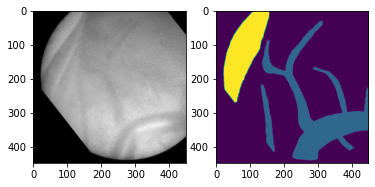

In [9]:
plt.figure()
plt.subplot(121)
plt.imshow(image[0][0],cmap='gray')
plt.subplot(122)
plt.imshow(np.argmax(mask[0], axis=0))

In [10]:
model = FPN(num_blocks=[3, 8, 36, 3], num_classes=4, back_bone="resnet152")
model.load_state_dict(torch.load('model-fold-0.pt',map_location="cpu"))
model=model.to(device)

In [11]:
model.eval()
predicted = model(image)

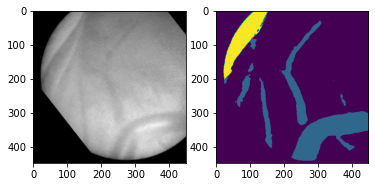

In [12]:
plt.figure()
plt.subplot(121)
plt.imshow(image[0][0],cmap='gray')
plt.subplot(122)
plt.imshow(np.argmax(predicted[0].detach().numpy(), axis=0))

In [13]:

image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(mask).float()
image , label = image.to(device), label.to(device)

<ipython-input-13-7de95ce8ff4d>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image , label = torch.tensor(image, requires_grad=True).float(), torch.tensor(mask).float()


In [14]:
label.shape

torch.Size([1, 4, 448, 448])

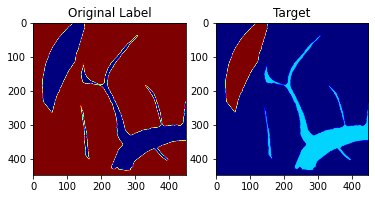

In [15]:
# label_oh=make_one_hot(label.long(), 2,device)
adv_target=generate_target(label.cpu().numpy(), target_class=0)
adv_target=torch.from_numpy(adv_target).float()
adv_target=adv_target.to(device)

#Visualizing the target
_, adv=torch.max(adv_target,1)
adv=adv[0].cpu().numpy()
plt.figure()
plt.subplot(121)
plt.title('Original Label')
plt.imshow(label[0][0].cpu().numpy(),cmap='jet')
plt.subplot(122)
plt.title('Target')
plt.imshow(adv,cmap='jet')
plt.show()

In [20]:
num_iterations=20
gamma=0.5
num=4
model = FPN(num_blocks=[3, 8, 36, 3], num_classes=4, back_bone="resnet152")
model.load_state_dict(torch.load('model-fold-0.pt',map_location="cpu"))
model=model.to(device)
image_adv,output_clean, noise_total, noise_iteration, prediction_iteration, image_iteration=DAG(model=model,
              image=image,
              ground_truth=mask[0],
              adv_target=adv_target,
              num_iterations=num_iterations,
              gamma=gamma,
              no_background=True,
              background_class=0,
              device=device,
              verbose=False)

Condition Reached, no gradient


In [19]:
label.shape

torch.Size([1, 4, 448, 448])

In [21]:
image_iteration

[array([[1.1836885e-03, 1.5780155e-03, 1.1932914e-03, ..., 6.1749242e-06,
         0.0000000e+00, 0.0000000e+00],
        [1.8709641e-03, 2.6887695e-03, 2.2652196e-03, ..., 1.4579796e-05,
         6.0658090e-07, 1.8712275e-07],
        [1.9986734e-03, 2.5437810e-03, 2.0538098e-03, ..., 2.9250648e-05,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.8508750e-06,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 3.3259124e-07, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 4.7479810e-07, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32),
 array([[1.7062627e-03, 2.3137496e-03, 1.6446431e-03, ..., 7.2434399e-05,
         0.0000000e+00, 0.0000000e+00],
        [2.4659270e-03, 3.7160600e-03, 3.2893983e-03, ..., 4.8793885e-05,
         0.0000000e+00, 0.0000000e+00],
        [2.4759166e-03, 3.4185571e-03, 3.4265216e-03, ...,

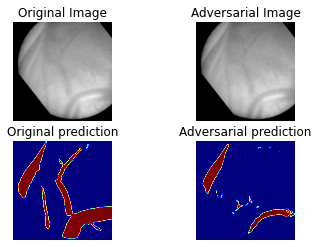

In [22]:

plt.figure()
plt.subplot(221)
plt.title('Original Image')
plt.imshow(image_iteration[0],cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.title('Adversarial Image')
plt.imshow(image_iteration[-1],cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.title('Original prediction')
plt.imshow(prediction_iteration[0],cmap='jet')
plt.axis('off')
plt.subplot(224)
plt.title('Adversarial prediction')
plt.imshow(prediction_iteration[-1],cmap='jet')
plt.axis('off')
plt.show()
